In [1]:
from bs4 import BeautifulSoup as bs4
from datetime import date
from sklearn import preprocessing
import pandas as pd
import numpy as np
import requests
import os
import csv
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import InputLayer
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy 

Using TensorFlow backend.


Pulls data from websites and stores them in csv files

In [2]:
def update_data():
    positive_cases_csv_URL = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
    req = requests.get(positive_cases_csv_URL)
    URL_content = req.content
    positive_cases_file = open("positive_cases.csv", "wb")
    positive_cases_file.write(URL_content)
    positive_cases_file.close()

This is purely for the sources of data that include data outside the UK as having international data would mean too much to parse through

In [3]:
def filter_data(filename):
    uk = list()
    with open(filename, 'r') as readFile:
        reader = csv.reader(readFile)
        for row in reader:
            if row[0] == "GBR" or row[0] == "iso_code":
                uk.append(row)
    
    with open(filename, 'w') as writeFile:
        writer = csv.writer(writeFile)
        writer.writerows(uk)  


Counts the number of days since the earliest data entry

In [4]:
def numberofdays(date_in_question):
    start_date = date(2020, 1, 31)
    dateq = date_in_question.split("-")
    cdate = date(int(dateq[0]), int(dateq[1]), int(dateq[2]))
    return (cdate - start_date).days

This will normalise all the data in a dataframe

In [5]:
def normalise_dataframe(df):
    for i in range(1, len(df.columns)):
        maxi = max(df.iloc[:,i])
        mini = min(df.iloc[:,i])
        for j in range(len(df.iloc[:,0])):
            df.iloc[j, i] = (df.iloc[j, i] - mini)/(maxi-mini)

This will only take columns in the data frame with no NaNs

In [6]:
def no_NaNs(df):
    data = []
    for column in df.columns:
        temp = [float(i) for i in df[column]]
        if np.isnan(np.sum(np.array(temp))):
            df.drop([column], inplace=True, axis=1)

This will only take columns that don't have a single repeating entry

In [7]:
def no_repeat(df):
    data = []
    for column in df.columns:
        if df[column].nunique() == 1:
            df.drop([column], inplace=True, axis=1)

This will create the input array for the Neural Network

In [152]:
def create_features(df, window_size, forecast):
    features = []
    labels = []
    i = window_size;
    while i < len(df.iloc[:, 0]) - forecast-1:
        window = df.iloc[i - window_size: i, 1:]
        window = np.array(window)
        window = window.flatten()
        labels.append(df.iloc[i + forecast, 0])
        features.append(window)
        i += 1
    features = np.array(features)
    labels = np.array(labels)
    return features, labels

In [153]:
update_data() 

In [154]:
filter_data("positive_cases.csv")

Grabs the current working directory where the csv files are stored

In [155]:
working_dir = os.getcwd()

Reads the csv files into their respective dataframes

In [156]:
pos_cases_df = pd.read_csv(os.path.join(working_dir, "positive_cases.csv"))
pos_cases_df.drop(pos_cases_df.iloc[:, 0:3], inplace = True, axis=1)
dates = pos_cases_df["date"]
pos_cases_df.drop(["date"], inplace = True, axis=1)
pos_cases_df.drop(["tests_units"], inplace = True, axis=1)

In [157]:
no_NaNs(pos_cases_df)

In [158]:
no_repeat(pos_cases_df)

Code just adds a column to the dataframe that counts the number of days since the earliest data entry

In [159]:
daysSince = []
for i in range(len(pos_cases_df)):
    daysSince.append(i)
pos_cases_df["daysSince"] = daysSince

Here I make the feature and label matrices with a 7 day window and a 1 day forecast

In [160]:
window_size = 7
forecast = 1
features1, labels1 = create_features(pos_cases_df, window_size, forecast)

In [161]:
print(features.shape)
print(labels.shape)

(407, 28)
(407,)


Splitting the feature and label matrices into training and testing by 8:2. I will split the training further down into 8:2 again for validation.

In [162]:
training_features1, testing_features1 = np.split(features1, [int(0.8*len(features1))])
training_labels1, testing_labels1 = np.split(labels1, [int(0.8*len(labels1))])

In [164]:
input_shape = training_features1.shape[1]

In [165]:
NN_model = Sequential()
# Input layer
NN_model.add(Dense(128, input_dim=input_shape, kernel_initializer="normal", activation="relu"))
# Hidden Layers
NN_model.add(Dense(256, kernel_initializer="normal", activation="relu"))
NN_model.add(Dense(256, kernel_initializer="normal", activation="relu"))
NN_model.add(Dense(256, kernel_initializer="normal", activation="relu"))
# Output layer 
NN_model.add(Dense(1, kernel_initializer="normal", activation="linear"))

NN_model.compile(loss="mean_absolute_error", optimizer="adam", metrics=["accuracy"])
NN_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 128)               3712      
_________________________________________________________________
dense_27 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_28 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_29 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 257       
Total params: 168,577
Trainable params: 168,577
Non-trainable params: 0
_________________________________________________________________


In [166]:
history1 = NN_model.fit(training_features1, training_labels1, epochs=500, validation_split=0.2)

Train on 260 samples, validate on 65 samples
Epoch 1/500
260/260 [==============================] - 0s 552us/step - loss: 248235.0058 - accuracy: 0.0000e+00 - val_loss: 1527309.1115 - val_accuracy: 0.0000e+00
Epoch 2/500
260/260 [==============================] - 0s 92us/step - loss: 232682.3346 - accuracy: 0.0038 - val_loss: 1199516.4038 - val_accuracy: 0.0000e+00
Epoch 3/500
260/260 [==============================] - 0s 100us/step - loss: 129156.8024 - accuracy: 0.0000e+00 - val_loss: 574405.4923 - val_accuracy: 0.0000e+00
Epoch 4/500
260/260 [==============================] - 0s 96us/step - loss: 83401.7660 - accuracy: 0.0000e+00 - val_loss: 145590.8231 - val_accuracy: 0.0000e+00
Epoch 5/500
260/260 [==============================] - 0s 100us/step - loss: 46742.7131 - accuracy: 0.0000e+00 - val_loss: 90051.5096 - val_accuracy: 0.0000e+00
Epoch 6/500
260/260 [==============================] - 0s 111us/step - loss: 17740.9549 - accuracy: 0.0000e+00 - val_loss: 65435.9442 - val_accurac

260/260 [==============================] - 0s 96us/step - loss: 3030.2076 - accuracy: 0.0077 - val_loss: 33757.0596 - val_accuracy: 0.0000e+00
Epoch 53/500
260/260 [==============================] - 0s 100us/step - loss: 5416.5520 - accuracy: 0.0077 - val_loss: 18658.3087 - val_accuracy: 0.0000e+00
Epoch 54/500
260/260 [==============================] - 0s 92us/step - loss: 2883.3431 - accuracy: 0.0000e+00 - val_loss: 21758.0894 - val_accuracy: 0.0000e+00
Epoch 55/500
260/260 [==============================] - 0s 96us/step - loss: 3596.1554 - accuracy: 0.0000e+00 - val_loss: 7315.5183 - val_accuracy: 0.0000e+00
Epoch 56/500
260/260 [==============================] - 0s 96us/step - loss: 2011.4989 - accuracy: 0.0038 - val_loss: 26248.9788 - val_accuracy: 0.0000e+00
Epoch 57/500
260/260 [==============================] - 0s 96us/step - loss: 5099.3104 - accuracy: 0.0000e+00 - val_loss: 26628.1250 - val_accuracy: 0.0000e+00
Epoch 58/500
260/260 [==============================] - 0s 92us/s

260/260 [==============================] - 0s 96us/step - loss: 2263.0948 - accuracy: 0.0077 - val_loss: 56513.2385 - val_accuracy: 0.0000e+00
Epoch 105/500
260/260 [==============================] - 0s 104us/step - loss: 7575.2322 - accuracy: 0.0038 - val_loss: 90016.6808 - val_accuracy: 0.0000e+00
Epoch 106/500
260/260 [==============================] - 0s 96us/step - loss: 7290.9056 - accuracy: 0.0038 - val_loss: 20778.8875 - val_accuracy: 0.0000e+00
Epoch 107/500
260/260 [==============================] - 0s 96us/step - loss: 4074.1716 - accuracy: 0.0077 - val_loss: 18326.6519 - val_accuracy: 0.0000e+00
Epoch 108/500
260/260 [==============================] - 0s 96us/step - loss: 4077.1793 - accuracy: 0.0077 - val_loss: 6779.4981 - val_accuracy: 0.0000e+00
Epoch 109/500
260/260 [==============================] - 0s 96us/step - loss: 2791.6499 - accuracy: 0.0077 - val_loss: 9133.6413 - val_accuracy: 0.0000e+00
Epoch 110/500
260/260 [==============================] - 0s 100us/step - 

Epoch 156/500
260/260 [==============================] - 0s 96us/step - loss: 3473.8426 - accuracy: 0.0115 - val_loss: 18391.7875 - val_accuracy: 0.0000e+00
Epoch 157/500
260/260 [==============================] - 0s 100us/step - loss: 2776.8336 - accuracy: 0.0038 - val_loss: 25298.2606 - val_accuracy: 0.0000e+00
Epoch 158/500
260/260 [==============================] - 0s 96us/step - loss: 1712.8962 - accuracy: 0.0115 - val_loss: 16691.7990 - val_accuracy: 0.0000e+00
Epoch 159/500
260/260 [==============================] - 0s 96us/step - loss: 1621.0731 - accuracy: 0.0231 - val_loss: 33132.4817 - val_accuracy: 0.0000e+00
Epoch 160/500
260/260 [==============================] - 0s 104us/step - loss: 3289.7287 - accuracy: 0.0000e+00 - val_loss: 5957.5837 - val_accuracy: 0.0000e+00
Epoch 161/500
260/260 [==============================] - 0s 104us/step - loss: 3267.5338 - accuracy: 0.0000e+00 - val_loss: 19267.2875 - val_accuracy: 0.0000e+00
Epoch 162/500
260/260 [=========================

Epoch 208/500
260/260 [==============================] - 0s 96us/step - loss: 4078.9462 - accuracy: 0.0038 - val_loss: 10963.9692 - val_accuracy: 0.0000e+00
Epoch 209/500
260/260 [==============================] - 0s 92us/step - loss: 2609.1847 - accuracy: 0.0115 - val_loss: 11424.8875 - val_accuracy: 0.0000e+00
Epoch 210/500
260/260 [==============================] - 0s 92us/step - loss: 2432.3834 - accuracy: 0.0077 - val_loss: 7256.3962 - val_accuracy: 0.0000e+00
Epoch 211/500
260/260 [==============================] - 0s 92us/step - loss: 1769.2321 - accuracy: 0.0154 - val_loss: 25787.2087 - val_accuracy: 0.0000e+00
Epoch 212/500
260/260 [==============================] - 0s 92us/step - loss: 5140.6748 - accuracy: 0.0192 - val_loss: 7995.4038 - val_accuracy: 0.0000e+00
Epoch 213/500
260/260 [==============================] - 0s 92us/step - loss: 6644.1292 - accuracy: 0.0077 - val_loss: 46975.6577 - val_accuracy: 0.0000e+00
Epoch 214/500
260/260 [==============================] - 0s 

260/260 [==============================] - 0s 92us/step - loss: 1335.2290 - accuracy: 0.0000e+00 - val_loss: 8911.6663 - val_accuracy: 0.0000e+00
Epoch 261/500
260/260 [==============================] - 0s 96us/step - loss: 1987.4470 - accuracy: 0.0000e+00 - val_loss: 11337.0913 - val_accuracy: 0.0000e+00
Epoch 262/500
260/260 [==============================] - 0s 92us/step - loss: 4019.6091 - accuracy: 0.0154 - val_loss: 9166.1135 - val_accuracy: 0.0000e+00
Epoch 263/500
260/260 [==============================] - 0s 96us/step - loss: 2747.4308 - accuracy: 0.0000e+00 - val_loss: 25547.2615 - val_accuracy: 0.0000e+00
Epoch 264/500
260/260 [==============================] - 0s 96us/step - loss: 3743.4011 - accuracy: 0.0115 - val_loss: 8251.9702 - val_accuracy: 0.0000e+00
Epoch 265/500
260/260 [==============================] - 0s 96us/step - loss: 1972.3827 - accuracy: 0.0115 - val_loss: 10202.8106 - val_accuracy: 0.0000e+00
Epoch 266/500
260/260 [==============================] - 0s 96u

260/260 [==============================] - 0s 96us/step - loss: 1796.2065 - accuracy: 0.0231 - val_loss: 9303.1875 - val_accuracy: 0.0000e+00
Epoch 313/500
260/260 [==============================] - 0s 100us/step - loss: 1409.8610 - accuracy: 0.0192 - val_loss: 20893.3731 - val_accuracy: 0.0000e+00
Epoch 314/500
260/260 [==============================] - 0s 88us/step - loss: 3859.3878 - accuracy: 0.0115 - val_loss: 38712.6510 - val_accuracy: 0.0000e+00
Epoch 315/500
260/260 [==============================] - 0s 104us/step - loss: 4528.9621 - accuracy: 0.0077 - val_loss: 25284.0788 - val_accuracy: 0.0000e+00
Epoch 316/500
260/260 [==============================] - 0s 92us/step - loss: 4088.8556 - accuracy: 0.0154 - val_loss: 13827.0183 - val_accuracy: 0.0000e+00
Epoch 317/500
260/260 [==============================] - 0s 96us/step - loss: 1683.1194 - accuracy: 0.0077 - val_loss: 9538.0462 - val_accuracy: 0.0000e+00
Epoch 318/500
260/260 [==============================] - 0s 96us/step - 

260/260 [==============================] - 0s 104us/step - loss: 2787.5381 - accuracy: 0.0038 - val_loss: 29853.1933 - val_accuracy: 0.0000e+00
Epoch 365/500
260/260 [==============================] - 0s 96us/step - loss: 3180.6870 - accuracy: 0.0231 - val_loss: 14804.6058 - val_accuracy: 0.0000e+00
Epoch 366/500
260/260 [==============================] - 0s 96us/step - loss: 3274.6684 - accuracy: 0.0038 - val_loss: 33747.0846 - val_accuracy: 0.0000e+00
Epoch 367/500
260/260 [==============================] - 0s 96us/step - loss: 4636.6653 - accuracy: 0.0192 - val_loss: 9100.7538 - val_accuracy: 0.0000e+00
Epoch 368/500
260/260 [==============================] - 0s 96us/step - loss: 4839.7947 - accuracy: 0.0115 - val_loss: 48423.3481 - val_accuracy: 0.0000e+00
Epoch 369/500
260/260 [==============================] - 0s 96us/step - loss: 4686.9540 - accuracy: 0.0000e+00 - val_loss: 31492.3740 - val_accuracy: 0.0000e+00
Epoch 370/500
260/260 [==============================] - 0s 96us/ste

260/260 [==============================] - 0s 96us/step - loss: 1975.9464 - accuracy: 0.0346 - val_loss: 13652.0587 - val_accuracy: 0.0000e+00
Epoch 417/500
260/260 [==============================] - 0s 96us/step - loss: 1731.1336 - accuracy: 0.0115 - val_loss: 42445.1529 - val_accuracy: 0.0000e+00
Epoch 418/500
260/260 [==============================] - 0s 92us/step - loss: 6515.7045 - accuracy: 0.0038 - val_loss: 43733.4827 - val_accuracy: 0.0000e+00
Epoch 419/500
260/260 [==============================] - 0s 104us/step - loss: 3722.9643 - accuracy: 0.0038 - val_loss: 22794.5962 - val_accuracy: 0.0000e+00
Epoch 420/500
260/260 [==============================] - 0s 100us/step - loss: 4218.2486 - accuracy: 0.0038 - val_loss: 10516.4279 - val_accuracy: 0.0000e+00
Epoch 421/500
260/260 [==============================] - 0s 92us/step - loss: 1960.1129 - accuracy: 0.0000e+00 - val_loss: 13467.1981 - val_accuracy: 0.0000e+00
Epoch 422/500
260/260 [==============================] - 0s 81us/s

260/260 [==============================] - 0s 92us/step - loss: 5599.0107 - accuracy: 0.0269 - val_loss: 57070.4731 - val_accuracy: 0.0000e+00
Epoch 469/500
260/260 [==============================] - 0s 100us/step - loss: 5128.7648 - accuracy: 0.0115 - val_loss: 8092.4298 - val_accuracy: 0.0000e+00
Epoch 470/500
260/260 [==============================] - 0s 108us/step - loss: 3785.3315 - accuracy: 0.0231 - val_loss: 8762.1596 - val_accuracy: 0.0000e+00
Epoch 471/500
260/260 [==============================] - 0s 96us/step - loss: 2250.1420 - accuracy: 0.0077 - val_loss: 67590.3000 - val_accuracy: 0.0000e+00
Epoch 472/500
260/260 [==============================] - 0s 100us/step - loss: 7621.4194 - accuracy: 0.0269 - val_loss: 47352.5962 - val_accuracy: 0.0000e+00
Epoch 473/500
260/260 [==============================] - 0s 96us/step - loss: 6890.8182 - accuracy: 0.0154 - val_loss: 65876.4577 - val_accuracy: 0.0000e+00
Epoch 474/500
260/260 [==============================] - 0s 96us/step -

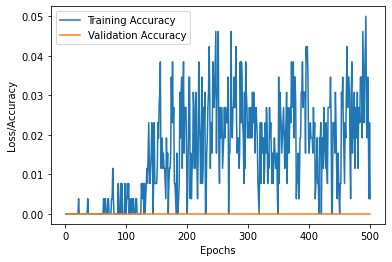

In [167]:
epochs = range(1, len(history1.epoch) + 1)
# plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history1.history['accuracy'], label='Training Accuracy')
# plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [150]:
x = [i for i in range(int(testing_features1[0,-1]+1), int(testing_features1[-1,-1]+2))]
y = testing_labels1
x_pred = testing_features1
y_pred = NN_model.predict(x_pred)    

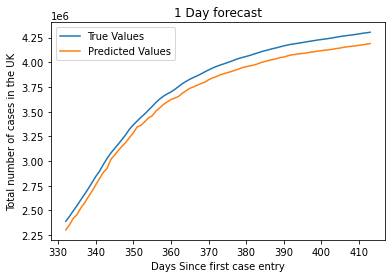

In [169]:
plt.plot(x, y, label="True Values")
plt.plot(x, y_pred, label="Predicted Values")
plt.xlabel("Days Since first case entry")
plt.ylabel("Total number of cases in the UK")
plt.title("1 Day forecast")
plt.legend()
plt.show()

Here I make a new feature and label matrix with a 7 day window and a 2 day forecast

In [170]:
window_size = 7
forecast = 2
features2, labels2 = create_features(pos_cases_df, window_size, forecast)

I split the matrices down into training and testing using a 8:2 splitting

In [171]:
training_features2, testing_features2 = np.split(features2, [int(0.8*len(features2))])
training_labels2, testing_labels2 = np.split(labels2, [int(0.8*len(labels2))])

The model has to be trained again with this new data

In [174]:
history2 = NN_model.fit(training_features2, training_labels2, epochs=500, validation_split=0.2)

Train on 259 samples, validate on 65 samples
Epoch 1/500
259/259 [==============================] - 0s 116us/step - loss: 4055.8657 - accuracy: 0.0077 - val_loss: 17549.1442 - val_accuracy: 0.0000e+00
Epoch 2/500
259/259 [==============================] - 0s 100us/step - loss: 3826.5108 - accuracy: 0.0077 - val_loss: 11922.8144 - val_accuracy: 0.0000e+00
Epoch 3/500
259/259 [==============================] - 0s 100us/step - loss: 2131.1087 - accuracy: 0.0039 - val_loss: 29077.4779 - val_accuracy: 0.0000e+00
Epoch 4/500
259/259 [==============================] - 0s 104us/step - loss: 2543.2533 - accuracy: 0.0116 - val_loss: 9254.6317 - val_accuracy: 0.0000e+00
Epoch 5/500
259/259 [==============================] - 0s 104us/step - loss: 1868.4488 - accuracy: 0.0039 - val_loss: 11904.9663 - val_accuracy: 0.0000e+00
Epoch 6/500
259/259 [==============================] - 0s 96us/step - loss: 2295.3199 - accuracy: 0.0309 - val_loss: 10919.8106 - val_accuracy: 0.0000e+00
Epoch 7/500
259/259 [

259/259 [==============================] - 0s 93us/step - loss: 3786.8351 - accuracy: 0.0232 - val_loss: 16813.1144 - val_accuracy: 0.0000e+00
Epoch 54/500
259/259 [==============================] - 0s 96us/step - loss: 2674.0856 - accuracy: 0.0116 - val_loss: 20194.5279 - val_accuracy: 0.0000e+00
Epoch 55/500
259/259 [==============================] - 0s 100us/step - loss: 4286.7766 - accuracy: 0.0077 - val_loss: 53060.5442 - val_accuracy: 0.0000e+00
Epoch 56/500
259/259 [==============================] - 0s 100us/step - loss: 9707.5658 - accuracy: 0.0193 - val_loss: 12907.5250 - val_accuracy: 0.0000e+00
Epoch 57/500
259/259 [==============================] - 0s 96us/step - loss: 8400.9096 - accuracy: 0.0154 - val_loss: 13797.8337 - val_accuracy: 0.0000e+00
Epoch 58/500
259/259 [==============================] - 0s 96us/step - loss: 6297.5957 - accuracy: 0.0270 - val_loss: 20369.1683 - val_accuracy: 0.0000e+00
Epoch 59/500
259/259 [==============================] - 0s 96us/step - loss

259/259 [==============================] - 0s 96us/step - loss: 3143.4391 - accuracy: 0.0193 - val_loss: 18763.0596 - val_accuracy: 0.0000e+00
Epoch 106/500
259/259 [==============================] - 0s 108us/step - loss: 2334.5752 - accuracy: 0.0116 - val_loss: 15092.0394 - val_accuracy: 0.0000e+00
Epoch 107/500
259/259 [==============================] - 0s 100us/step - loss: 2046.1948 - accuracy: 0.0116 - val_loss: 16759.6308 - val_accuracy: 0.0000e+00
Epoch 108/500
259/259 [==============================] - 0s 96us/step - loss: 2799.5860 - accuracy: 0.0232 - val_loss: 18374.6413 - val_accuracy: 0.0000e+00
Epoch 109/500
259/259 [==============================] - 0s 104us/step - loss: 3316.3385 - accuracy: 0.0154 - val_loss: 24363.7596 - val_accuracy: 0.0000e+00
Epoch 110/500
259/259 [==============================] - 0s 96us/step - loss: 3361.4834 - accuracy: 0.0116 - val_loss: 19705.5029 - val_accuracy: 0.0000e+00
Epoch 111/500
259/259 [==============================] - 0s 96us/step

Epoch 157/500
259/259 [==============================] - 0s 96us/step - loss: 2643.3982 - accuracy: 0.0232 - val_loss: 20039.3240 - val_accuracy: 0.0000e+00
Epoch 158/500
259/259 [==============================] - 0s 100us/step - loss: 2962.1817 - accuracy: 0.0116 - val_loss: 40394.0673 - val_accuracy: 0.0000e+00
Epoch 159/500
259/259 [==============================] - 0s 96us/step - loss: 3756.1682 - accuracy: 0.0039 - val_loss: 18340.8115 - val_accuracy: 0.0000e+00
Epoch 160/500
259/259 [==============================] - 0s 96us/step - loss: 4585.7346 - accuracy: 0.0270 - val_loss: 31871.1019 - val_accuracy: 0.0000e+00
Epoch 161/500
259/259 [==============================] - 0s 104us/step - loss: 5221.2866 - accuracy: 0.0386 - val_loss: 22132.6885 - val_accuracy: 0.0000e+00
Epoch 162/500
259/259 [==============================] - 0s 93us/step - loss: 3569.0584 - accuracy: 0.0232 - val_loss: 40110.2558 - val_accuracy: 0.0000e+00
Epoch 163/500
259/259 [==============================] -

259/259 [==============================] - 0s 104us/step - loss: 1677.6587 - accuracy: 0.0347 - val_loss: 18206.2413 - val_accuracy: 0.0000e+00
Epoch 210/500
259/259 [==============================] - 0s 93us/step - loss: 2151.9118 - accuracy: 0.0270 - val_loss: 22856.3519 - val_accuracy: 0.0000e+00
Epoch 211/500
259/259 [==============================] - 0s 93us/step - loss: 3593.2862 - accuracy: 0.0154 - val_loss: 9912.1077 - val_accuracy: 0.0000e+00
Epoch 212/500
259/259 [==============================] - 0s 93us/step - loss: 2123.1657 - accuracy: 0.0232 - val_loss: 39628.5654 - val_accuracy: 0.0000e+00
Epoch 213/500
259/259 [==============================] - 0s 93us/step - loss: 5298.5093 - accuracy: 0.0116 - val_loss: 54358.8904 - val_accuracy: 0.0000e+00
Epoch 214/500
259/259 [==============================] - 0s 93us/step - loss: 6914.9147 - accuracy: 0.0193 - val_loss: 40377.3337 - val_accuracy: 0.0000e+00
Epoch 215/500
259/259 [==============================] - 0s 96us/step - 

259/259 [==============================] - 0s 96us/step - loss: 2302.5172 - accuracy: 0.0000e+00 - val_loss: 10602.7365 - val_accuracy: 0.0000e+00
Epoch 262/500
259/259 [==============================] - 0s 96us/step - loss: 3277.0676 - accuracy: 0.0232 - val_loss: 13855.9692 - val_accuracy: 0.0000e+00
Epoch 263/500
259/259 [==============================] - 0s 93us/step - loss: 2772.1142 - accuracy: 0.0193 - val_loss: 21357.2856 - val_accuracy: 0.0000e+00
Epoch 264/500
259/259 [==============================] - 0s 96us/step - loss: 2019.2244 - accuracy: 0.0232 - val_loss: 18456.1731 - val_accuracy: 0.0000e+00
Epoch 265/500
259/259 [==============================] - 0s 96us/step - loss: 2170.3313 - accuracy: 0.0077 - val_loss: 9784.8798 - val_accuracy: 0.0000e+00
Epoch 266/500
259/259 [==============================] - 0s 96us/step - loss: 2241.0660 - accuracy: 0.0116 - val_loss: 18285.7635 - val_accuracy: 0.0000e+00
Epoch 267/500
259/259 [==============================] - 0s 96us/step

Epoch 313/500
259/259 [==============================] - 0s 96us/step - loss: 2353.4580 - accuracy: 0.0116 - val_loss: 24930.9538 - val_accuracy: 0.0000e+00
Epoch 314/500
259/259 [==============================] - 0s 93us/step - loss: 2663.8180 - accuracy: 0.0116 - val_loss: 13817.1288 - val_accuracy: 0.0000e+00
Epoch 315/500
259/259 [==============================] - 0s 93us/step - loss: 2504.8187 - accuracy: 0.0000e+00 - val_loss: 10841.3971 - val_accuracy: 0.0000e+00
Epoch 316/500
259/259 [==============================] - 0s 93us/step - loss: 2796.0997 - accuracy: 0.0270 - val_loss: 31309.5298 - val_accuracy: 0.0000e+00
Epoch 317/500
259/259 [==============================] - 0s 93us/step - loss: 3576.6639 - accuracy: 0.0077 - val_loss: 29381.9163 - val_accuracy: 0.0000e+00
Epoch 318/500
259/259 [==============================] - 0s 93us/step - loss: 4478.0028 - accuracy: 0.0116 - val_loss: 17911.2663 - val_accuracy: 0.0000e+00
Epoch 319/500
259/259 [==============================]

259/259 [==============================] - 0s 96us/step - loss: 1962.7105 - accuracy: 0.0039 - val_loss: 37999.4173 - val_accuracy: 0.0000e+00
Epoch 366/500
259/259 [==============================] - 0s 100us/step - loss: 4605.4749 - accuracy: 0.0039 - val_loss: 10334.7019 - val_accuracy: 0.0000e+00
Epoch 367/500
259/259 [==============================] - 0s 93us/step - loss: 2433.3817 - accuracy: 0.0000e+00 - val_loss: 17741.9442 - val_accuracy: 0.0000e+00
Epoch 368/500
259/259 [==============================] - 0s 93us/step - loss: 2220.6076 - accuracy: 0.0039 - val_loss: 16655.8865 - val_accuracy: 0.0000e+00
Epoch 369/500
259/259 [==============================] - 0s 93us/step - loss: 1549.6413 - accuracy: 0.0116 - val_loss: 22168.8125 - val_accuracy: 0.0000e+00
Epoch 370/500
259/259 [==============================] - 0s 93us/step - loss: 3191.4554 - accuracy: 0.0154 - val_loss: 42719.9183 - val_accuracy: 0.0000e+00
Epoch 371/500
259/259 [==============================] - 0s 100us/s

259/259 [==============================] - 0s 93us/step - loss: 3124.7068 - accuracy: 0.0116 - val_loss: 9580.6558 - val_accuracy: 0.0000e+00
Epoch 418/500
259/259 [==============================] - 0s 96us/step - loss: 1511.9208 - accuracy: 0.0000e+00 - val_loss: 20442.3385 - val_accuracy: 0.0000e+00
Epoch 419/500
259/259 [==============================] - 0s 93us/step - loss: 4799.2084 - accuracy: 0.0116 - val_loss: 30906.8712 - val_accuracy: 0.0000e+00
Epoch 420/500
259/259 [==============================] - 0s 93us/step - loss: 6118.8168 - accuracy: 0.0116 - val_loss: 34596.4462 - val_accuracy: 0.0000e+00
Epoch 421/500
259/259 [==============================] - 0s 93us/step - loss: 4939.4662 - accuracy: 0.0116 - val_loss: 23760.6702 - val_accuracy: 0.0000e+00
Epoch 422/500
259/259 [==============================] - 0s 96us/step - loss: 2985.3395 - accuracy: 0.0039 - val_loss: 16668.0798 - val_accuracy: 0.0000e+00
Epoch 423/500
259/259 [==============================] - 0s 93us/step

259/259 [==============================] - 0s 93us/step - loss: 1778.0424 - accuracy: 0.0270 - val_loss: 12009.9615 - val_accuracy: 0.0000e+00
Epoch 470/500
259/259 [==============================] - 0s 96us/step - loss: 1564.7256 - accuracy: 0.0193 - val_loss: 41030.0365 - val_accuracy: 0.0000e+00
Epoch 471/500
259/259 [==============================] - 0s 93us/step - loss: 4613.1719 - accuracy: 0.0347 - val_loss: 12177.6567 - val_accuracy: 0.0000e+00
Epoch 472/500
259/259 [==============================] - 0s 96us/step - loss: 4603.7359 - accuracy: 0.0309 - val_loss: 51737.1462 - val_accuracy: 0.0000e+00
Epoch 473/500
259/259 [==============================] - 0s 96us/step - loss: 6601.3192 - accuracy: 0.0232 - val_loss: 76945.6269 - val_accuracy: 0.0000e+00
Epoch 474/500
259/259 [==============================] - 0s 93us/step - loss: 7046.1125 - accuracy: 0.0347 - val_loss: 62463.6654 - val_accuracy: 0.0000e+00
Epoch 475/500
259/259 [==============================] - 0s 93us/step - 

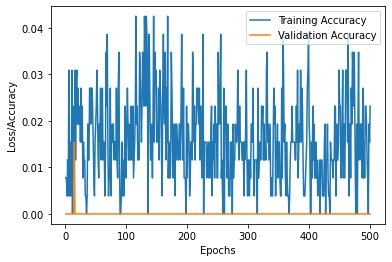

In [176]:
epochs = range(1, len(history2.epoch) + 1)
# plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history2.history['accuracy'], label='Training Accuracy')
# plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [177]:
x = [i for i in range(int(testing_features2[0,-1]+1), int(testing_features2[-1,-1]+2))]
y = testing_labels2
x_pred = testing_features2
y_pred = NN_model.predict(x_pred) 

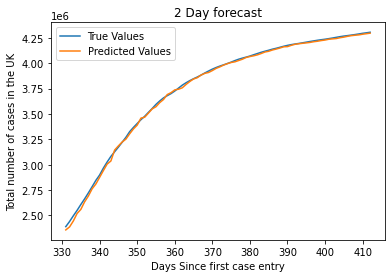

In [178]:
plt.plot(x, y, label="True Values")
plt.plot(x, y_pred, label="Predicted Values")
plt.xlabel("Days Since first case entry")
plt.ylabel("Total number of cases in the UK")
plt.title("2 Day forecast")
plt.legend()
plt.show()

In [179]:
window_size = 7
forecast = 3
features3, labels3 = create_features(pos_cases_df, window_size, forecast)

In [180]:
training_features3, testing_features3 = np.split(features3, [int(0.8*len(features3))])
training_labels3, testing_labels3 = np.split(labels3, [int(0.8*len(labels3))])

In [181]:
history3 = NN_model.fit(training_features3, training_labels3, epochs=500, validation_split=0.2)

Train on 259 samples, validate on 65 samples
Epoch 1/500
259/259 [==============================] - 0s 108us/step - loss: 3494.4511 - accuracy: 0.0116 - val_loss: 16174.2952 - val_accuracy: 0.0000e+00
Epoch 2/500
259/259 [==============================] - 0s 100us/step - loss: 2492.3662 - accuracy: 0.0039 - val_loss: 27512.3077 - val_accuracy: 0.0000e+00
Epoch 3/500
259/259 [==============================] - 0s 100us/step - loss: 3867.4261 - accuracy: 0.0039 - val_loss: 18796.8702 - val_accuracy: 0.0000e+00
Epoch 4/500
259/259 [==============================] - 0s 96us/step - loss: 2651.8646 - accuracy: 0.0154 - val_loss: 34369.2144 - val_accuracy: 0.0000e+00
Epoch 5/500
259/259 [==============================] - 0s 116us/step - loss: 3554.2629 - accuracy: 0.0232 - val_loss: 22101.5702 - val_accuracy: 0.0000e+00
Epoch 6/500
259/259 [==============================] - 0s 112us/step - loss: 3506.7404 - accuracy: 0.0154 - val_loss: 23663.7808 - val_accuracy: 0.0000e+00
Epoch 7/500
259/259 

259/259 [==============================] - 0s 100us/step - loss: 2841.3576 - accuracy: 0.0270 - val_loss: 14530.7885 - val_accuracy: 0.0000e+00
Epoch 53/500
259/259 [==============================] - 0s 96us/step - loss: 1945.2090 - accuracy: 0.0116 - val_loss: 36000.7865 - val_accuracy: 0.0000e+00
Epoch 54/500
259/259 [==============================] - 0s 96us/step - loss: 2765.1998 - accuracy: 0.0193 - val_loss: 17458.0019 - val_accuracy: 0.0000e+00
Epoch 55/500
259/259 [==============================] - 0s 93us/step - loss: 2502.6960 - accuracy: 0.0193 - val_loss: 18402.1779 - val_accuracy: 0.0000e+00
Epoch 56/500
259/259 [==============================] - 0s 100us/step - loss: 2044.0276 - accuracy: 0.0077 - val_loss: 15512.3212 - val_accuracy: 0.0000e+00
Epoch 57/500
259/259 [==============================] - 0s 96us/step - loss: 1929.1642 - accuracy: 0.0077 - val_loss: 24209.8990 - val_accuracy: 0.0000e+00
Epoch 58/500
259/259 [==============================] - 0s 96us/step - loss

259/259 [==============================] - 0s 100us/step - loss: 2902.2857 - accuracy: 0.0154 - val_loss: 26245.0462 - val_accuracy: 0.0000e+00
Epoch 105/500
259/259 [==============================] - 0s 100us/step - loss: 2905.5980 - accuracy: 0.0077 - val_loss: 21252.0202 - val_accuracy: 0.0000e+00
Epoch 106/500
259/259 [==============================] - 0s 100us/step - loss: 2880.2613 - accuracy: 0.0193 - val_loss: 14932.8827 - val_accuracy: 0.0000e+00
Epoch 107/500
259/259 [==============================] - 0s 93us/step - loss: 2616.7827 - accuracy: 0.0077 - val_loss: 22630.3000 - val_accuracy: 0.0000e+00
Epoch 108/500
259/259 [==============================] - 0s 96us/step - loss: 2401.5456 - accuracy: 0.0000e+00 - val_loss: 14427.6731 - val_accuracy: 0.0000e+00
Epoch 109/500
259/259 [==============================] - 0s 93us/step - loss: 2171.4072 - accuracy: 0.0232 - val_loss: 20460.9712 - val_accuracy: 0.0000e+00
Epoch 110/500
259/259 [==============================] - 0s 93us/

259/259 [==============================] - 0s 108us/step - loss: 1882.7734 - accuracy: 0.0039 - val_loss: 26999.0788 - val_accuracy: 0.0000e+00
Epoch 156/500
259/259 [==============================] - 0s 104us/step - loss: 2601.2709 - accuracy: 0.0116 - val_loss: 26839.3933 - val_accuracy: 0.0000e+00
Epoch 157/500
259/259 [==============================] - 0s 96us/step - loss: 3583.7555 - accuracy: 0.0154 - val_loss: 14844.2923 - val_accuracy: 0.0000e+00
Epoch 158/500
259/259 [==============================] - 0s 104us/step - loss: 2378.4816 - accuracy: 0.0154 - val_loss: 18270.1615 - val_accuracy: 0.0000e+00
Epoch 159/500
259/259 [==============================] - 0s 100us/step - loss: 3403.9111 - accuracy: 0.0039 - val_loss: 13751.2077 - val_accuracy: 0.0000e+00
Epoch 160/500
259/259 [==============================] - 0s 96us/step - loss: 1832.1838 - accuracy: 0.0116 - val_loss: 26682.7990 - val_accuracy: 0.0000e+00
Epoch 161/500
259/259 [==============================] - 0s 100us/st

Epoch 207/500
259/259 [==============================] - 0s 93us/step - loss: 2945.8390 - accuracy: 0.0039 - val_loss: 37550.3856 - val_accuracy: 0.0000e+00
Epoch 208/500
259/259 [==============================] - 0s 96us/step - loss: 4185.9504 - accuracy: 0.0000e+00 - val_loss: 12992.9183 - val_accuracy: 0.0000e+00
Epoch 209/500
259/259 [==============================] - 0s 93us/step - loss: 2326.6867 - accuracy: 0.0309 - val_loss: 18251.7971 - val_accuracy: 0.0000e+00
Epoch 210/500
259/259 [==============================] - 0s 96us/step - loss: 3098.7515 - accuracy: 0.0116 - val_loss: 22121.1173 - val_accuracy: 0.0000e+00
Epoch 211/500
259/259 [==============================] - 0s 96us/step - loss: 3196.8945 - accuracy: 0.0077 - val_loss: 16166.0510 - val_accuracy: 0.0000e+00
Epoch 212/500
259/259 [==============================] - 0s 96us/step - loss: 2143.9441 - accuracy: 0.0000e+00 - val_loss: 15641.2269 - val_accuracy: 0.0000e+00
Epoch 213/500
259/259 [===========================

Epoch 259/500
259/259 [==============================] - 0s 96us/step - loss: 3542.9892 - accuracy: 0.0039 - val_loss: 11750.0952 - val_accuracy: 0.0000e+00
Epoch 260/500
259/259 [==============================] - 0s 93us/step - loss: 4163.7227 - accuracy: 0.0116 - val_loss: 44173.0452 - val_accuracy: 0.0000e+00
Epoch 261/500
259/259 [==============================] - 0s 96us/step - loss: 4653.9767 - accuracy: 0.0077 - val_loss: 18305.3702 - val_accuracy: 0.0000e+00
Epoch 262/500
259/259 [==============================] - 0s 93us/step - loss: 5348.6701 - accuracy: 0.0116 - val_loss: 34218.0846 - val_accuracy: 0.0000e+00
Epoch 263/500
259/259 [==============================] - 0s 96us/step - loss: 3941.3792 - accuracy: 0.0039 - val_loss: 37744.9923 - val_accuracy: 0.0000e+00
Epoch 264/500
259/259 [==============================] - 0s 93us/step - loss: 5125.8157 - accuracy: 0.0039 - val_loss: 25661.1183 - val_accuracy: 0.0000e+00
Epoch 265/500
259/259 [==============================] - 0

Epoch 311/500
259/259 [==============================] - 0s 96us/step - loss: 3337.0380 - accuracy: 0.0154 - val_loss: 24763.5596 - val_accuracy: 0.0000e+00
Epoch 312/500
259/259 [==============================] - 0s 93us/step - loss: 6209.0463 - accuracy: 0.0077 - val_loss: 50765.5173 - val_accuracy: 0.0000e+00
Epoch 313/500
259/259 [==============================] - 0s 96us/step - loss: 8559.5960 - accuracy: 0.0116 - val_loss: 16324.3462 - val_accuracy: 0.0000e+00
Epoch 314/500
259/259 [==============================] - 0s 96us/step - loss: 2838.2623 - accuracy: 0.0077 - val_loss: 18937.8394 - val_accuracy: 0.0000e+00
Epoch 315/500
259/259 [==============================] - 0s 93us/step - loss: 1954.8740 - accuracy: 0.0154 - val_loss: 18630.0433 - val_accuracy: 0.0000e+00
Epoch 316/500
259/259 [==============================] - 0s 93us/step - loss: 1964.6625 - accuracy: 0.0000e+00 - val_loss: 18180.6221 - val_accuracy: 0.0000e+00
Epoch 317/500
259/259 [==============================]

259/259 [==============================] - 0s 93us/step - loss: 1823.3283 - accuracy: 0.0193 - val_loss: 29822.4962 - val_accuracy: 0.0000e+00
Epoch 364/500
259/259 [==============================] - 0s 96us/step - loss: 2678.1147 - accuracy: 0.0154 - val_loss: 24523.0942 - val_accuracy: 0.0000e+00
Epoch 365/500
259/259 [==============================] - 0s 100us/step - loss: 2551.8033 - accuracy: 0.0154 - val_loss: 19642.9990 - val_accuracy: 0.0000e+00
Epoch 366/500
259/259 [==============================] - 0s 96us/step - loss: 2188.3465 - accuracy: 0.0193 - val_loss: 28970.9904 - val_accuracy: 0.0000e+00
Epoch 367/500
259/259 [==============================] - 0s 93us/step - loss: 2602.1135 - accuracy: 0.0347 - val_loss: 26402.0548 - val_accuracy: 0.0000e+00
Epoch 368/500
259/259 [==============================] - 0s 93us/step - loss: 3036.8898 - accuracy: 0.0077 - val_loss: 15648.3692 - val_accuracy: 0.0000e+00
Epoch 369/500
259/259 [==============================] - 0s 93us/step -

259/259 [==============================] - 0s 96us/step - loss: 2001.5160 - accuracy: 0.0154 - val_loss: 22058.6442 - val_accuracy: 0.0000e+00
Epoch 416/500
259/259 [==============================] - 0s 100us/step - loss: 2760.6969 - accuracy: 0.0154 - val_loss: 13741.3106 - val_accuracy: 0.0000e+00
Epoch 417/500
259/259 [==============================] - 0s 96us/step - loss: 3131.2544 - accuracy: 0.0077 - val_loss: 22520.7519 - val_accuracy: 0.0000e+00
Epoch 418/500
259/259 [==============================] - 0s 93us/step - loss: 4751.4128 - accuracy: 0.0270 - val_loss: 25560.3577 - val_accuracy: 0.0000e+00
Epoch 419/500
259/259 [==============================] - 0s 93us/step - loss: 5218.9774 - accuracy: 0.0232 - val_loss: 30590.5442 - val_accuracy: 0.0000e+00
Epoch 420/500
259/259 [==============================] - 0s 93us/step - loss: 6381.8068 - accuracy: 0.0077 - val_loss: 12639.4192 - val_accuracy: 0.0000e+00
Epoch 421/500
259/259 [==============================] - 0s 93us/step -

Epoch 467/500
259/259 [==============================] - 0s 96us/step - loss: 1811.0612 - accuracy: 0.0077 - val_loss: 15135.0779 - val_accuracy: 0.0000e+00
Epoch 468/500
259/259 [==============================] - 0s 100us/step - loss: 1804.2920 - accuracy: 0.0154 - val_loss: 15416.9240 - val_accuracy: 0.0000e+00
Epoch 469/500
259/259 [==============================] - 0s 96us/step - loss: 2514.6123 - accuracy: 0.0116 - val_loss: 15441.7875 - val_accuracy: 0.0000e+00
Epoch 470/500
259/259 [==============================] - 0s 93us/step - loss: 2339.4568 - accuracy: 0.0077 - val_loss: 22919.4317 - val_accuracy: 0.0000e+00
Epoch 471/500
259/259 [==============================] - 0s 96us/step - loss: 2468.7398 - accuracy: 0.0077 - val_loss: 20921.6692 - val_accuracy: 0.0000e+00
Epoch 472/500
259/259 [==============================] - 0s 93us/step - loss: 2177.8272 - accuracy: 0.0116 - val_loss: 17887.8442 - val_accuracy: 0.0000e+00
Epoch 473/500
259/259 [==============================] - 

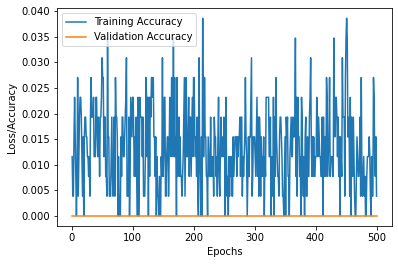

In [182]:
epochs = range(1, len(history3.epoch) + 1)
# plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history3.history['accuracy'], label='Training Accuracy')
# plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [183]:
x = [i for i in range(int(testing_features3[0,-1]+1), int(testing_features3[-1,-1]+2))]
y = testing_labels3
x_pred = testing_features3
y_pred = NN_model.predict(x_pred) 

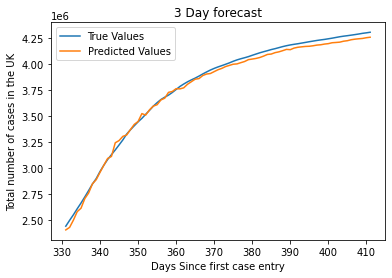

In [184]:
plt.plot(x, y, label="True Values")
plt.plot(x, y_pred, label="Predicted Values")
plt.xlabel("Days Since first case entry")
plt.ylabel("Total number of cases in the UK")
plt.title("3 Day forecast")
plt.legend()
plt.show()

In [186]:
window_size = 7
forecast = 10
features10, labels10 = create_features(pos_cases_df, window_size, forecast)

In [187]:
training_features10, testing_features10 = np.split(features10, [int(0.8*len(features10))])
training_labels10, testing_labels10 = np.split(labels10, [int(0.8*len(labels10))])

In [188]:
history10 = NN_model.fit(training_features10, training_labels10, epochs=500, validation_split=0.2)

Train on 254 samples, validate on 64 samples
Epoch 1/500
254/254 [==============================] - 0s 106us/step - loss: 20508.2920 - accuracy: 0.0039 - val_loss: 45007.2598 - val_accuracy: 0.0000e+00
Epoch 2/500
254/254 [==============================] - 0s 94us/step - loss: 15361.3723 - accuracy: 0.0000e+00 - val_loss: 78944.8477 - val_accuracy: 0.0000e+00
Epoch 3/500
254/254 [==============================] - 0s 98us/step - loss: 11671.7265 - accuracy: 0.0000e+00 - val_loss: 50033.7461 - val_accuracy: 0.0000e+00
Epoch 4/500
254/254 [==============================] - 0s 90us/step - loss: 10826.4452 - accuracy: 0.0000e+00 - val_loss: 67788.6074 - val_accuracy: 0.0000e+00
Epoch 5/500
254/254 [==============================] - 0s 94us/step - loss: 11137.9807 - accuracy: 0.0039 - val_loss: 62380.1504 - val_accuracy: 0.0000e+00
Epoch 6/500
254/254 [==============================] - 0s 102us/step - loss: 9141.4075 - accuracy: 0.0000e+00 - val_loss: 49321.8242 - val_accuracy: 0.0000e+00
Ep

254/254 [==============================] - 0s 87us/step - loss: 6449.5939 - accuracy: 0.0000e+00 - val_loss: 56403.4336 - val_accuracy: 0.0000e+00
Epoch 53/500
254/254 [==============================] - 0s 90us/step - loss: 6282.9548 - accuracy: 0.0000e+00 - val_loss: 56478.5977 - val_accuracy: 0.0000e+00
Epoch 54/500
254/254 [==============================] - 0s 90us/step - loss: 6245.5239 - accuracy: 0.0039 - val_loss: 52779.8047 - val_accuracy: 0.0000e+00
Epoch 55/500
254/254 [==============================] - 0s 90us/step - loss: 6138.1253 - accuracy: 0.0000e+00 - val_loss: 51842.6133 - val_accuracy: 0.0000e+00
Epoch 56/500
254/254 [==============================] - 0s 90us/step - loss: 6258.3065 - accuracy: 0.0039 - val_loss: 54817.0254 - val_accuracy: 0.0000e+00
Epoch 57/500
254/254 [==============================] - 0s 90us/step - loss: 6383.7003 - accuracy: 0.0079 - val_loss: 51443.1504 - val_accuracy: 0.0000e+00
Epoch 58/500
254/254 [==============================] - 0s 90us/s

Epoch 104/500
254/254 [==============================] - 0s 98us/step - loss: 5379.3380 - accuracy: 0.0000e+00 - val_loss: 56396.1738 - val_accuracy: 0.0000e+00
Epoch 105/500
254/254 [==============================] - 0s 94us/step - loss: 6378.9591 - accuracy: 0.0000e+00 - val_loss: 52302.2207 - val_accuracy: 0.0000e+00
Epoch 106/500
254/254 [==============================] - 0s 98us/step - loss: 5439.9916 - accuracy: 0.0039 - val_loss: 54977.1621 - val_accuracy: 0.0000e+00
Epoch 107/500
254/254 [==============================] - 0s 98us/step - loss: 5309.1759 - accuracy: 0.0039 - val_loss: 54584.0391 - val_accuracy: 0.0000e+00
Epoch 108/500
254/254 [==============================] - 0s 94us/step - loss: 5512.9928 - accuracy: 0.0000e+00 - val_loss: 56960.4512 - val_accuracy: 0.0000e+00
Epoch 109/500
254/254 [==============================] - 0s 94us/step - loss: 5460.8091 - accuracy: 0.0000e+00 - val_loss: 53207.7148 - val_accuracy: 0.0000e+00
Epoch 110/500
254/254 [===================

254/254 [==============================] - 0s 90us/step - loss: 5368.5641 - accuracy: 0.0000e+00 - val_loss: 56594.3223 - val_accuracy: 0.0000e+00
Epoch 156/500
254/254 [==============================] - 0s 94us/step - loss: 5302.6880 - accuracy: 0.0039 - val_loss: 55464.8418 - val_accuracy: 0.0000e+00
Epoch 157/500
254/254 [==============================] - 0s 94us/step - loss: 5911.7497 - accuracy: 0.0079 - val_loss: 58740.1016 - val_accuracy: 0.0000e+00
Epoch 158/500
254/254 [==============================] - 0s 90us/step - loss: 5065.4342 - accuracy: 0.0000e+00 - val_loss: 54730.7129 - val_accuracy: 0.0000e+00
Epoch 159/500
254/254 [==============================] - 0s 90us/step - loss: 5001.8522 - accuracy: 0.0039 - val_loss: 55193.5586 - val_accuracy: 0.0000e+00
Epoch 160/500
254/254 [==============================] - 0s 90us/step - loss: 5464.6045 - accuracy: 0.0000e+00 - val_loss: 59070.6465 - val_accuracy: 0.0000e+00
Epoch 161/500
254/254 [==============================] - 0s 

Epoch 207/500
254/254 [==============================] - 0s 94us/step - loss: 5059.1759 - accuracy: 0.0000e+00 - val_loss: 57537.7773 - val_accuracy: 0.0000e+00
Epoch 208/500
254/254 [==============================] - 0s 94us/step - loss: 5461.2146 - accuracy: 0.0039 - val_loss: 56889.4629 - val_accuracy: 0.0000e+00
Epoch 209/500
254/254 [==============================] - 0s 94us/step - loss: 5706.6651 - accuracy: 0.0039 - val_loss: 59066.2070 - val_accuracy: 0.0000e+00
Epoch 210/500
254/254 [==============================] - 0s 90us/step - loss: 5473.3050 - accuracy: 0.0039 - val_loss: 57381.2578 - val_accuracy: 0.0000e+00
Epoch 211/500
254/254 [==============================] - 0s 90us/step - loss: 5853.1490 - accuracy: 0.0039 - val_loss: 55291.6543 - val_accuracy: 0.0000e+00
Epoch 212/500
254/254 [==============================] - 0s 98us/step - loss: 5173.5807 - accuracy: 0.0000e+00 - val_loss: 57787.7852 - val_accuracy: 0.0000e+00
Epoch 213/500
254/254 [===========================

254/254 [==============================] - 0s 94us/step - loss: 5100.2405 - accuracy: 0.0039 - val_loss: 56396.6641 - val_accuracy: 0.0000e+00
Epoch 259/500
254/254 [==============================] - 0s 94us/step - loss: 5556.3392 - accuracy: 0.0000e+00 - val_loss: 68335.2871 - val_accuracy: 0.0000e+00
Epoch 260/500
254/254 [==============================] - 0s 94us/step - loss: 6517.0797 - accuracy: 0.0000e+00 - val_loss: 51366.6250 - val_accuracy: 0.0000e+00
Epoch 261/500
254/254 [==============================] - 0s 94us/step - loss: 6292.0831 - accuracy: 0.0000e+00 - val_loss: 58260.9453 - val_accuracy: 0.0000e+00
Epoch 262/500
254/254 [==============================] - 0s 94us/step - loss: 5349.6239 - accuracy: 0.0000e+00 - val_loss: 56015.2207 - val_accuracy: 0.0000e+00
Epoch 263/500
254/254 [==============================] - 0s 87us/step - loss: 5151.8969 - accuracy: 0.0000e+00 - val_loss: 60689.6758 - val_accuracy: 0.0000e+00
Epoch 264/500
254/254 [=============================

254/254 [==============================] - 0s 90us/step - loss: 5911.1075 - accuracy: 0.0000e+00 - val_loss: 67346.6895 - val_accuracy: 0.0000e+00
Epoch 310/500
254/254 [==============================] - 0s 94us/step - loss: 6848.9163 - accuracy: 0.0000e+00 - val_loss: 61316.2227 - val_accuracy: 0.0000e+00
Epoch 311/500
254/254 [==============================] - 0s 90us/step - loss: 6808.3456 - accuracy: 0.0079 - val_loss: 64228.2148 - val_accuracy: 0.0000e+00
Epoch 312/500
254/254 [==============================] - 0s 102us/step - loss: 5529.5320 - accuracy: 0.0039 - val_loss: 61374.9121 - val_accuracy: 0.0000e+00
Epoch 313/500
254/254 [==============================] - 0s 90us/step - loss: 5017.4435 - accuracy: 0.0000e+00 - val_loss: 58275.1328 - val_accuracy: 0.0000e+00
Epoch 314/500
254/254 [==============================] - 0s 94us/step - loss: 4938.1936 - accuracy: 0.0039 - val_loss: 59593.3574 - val_accuracy: 0.0000e+00
Epoch 315/500
254/254 [==============================] - 0s

Epoch 361/500
254/254 [==============================] - 0s 90us/step - loss: 6679.2963 - accuracy: 0.0079 - val_loss: 63593.0352 - val_accuracy: 0.0000e+00
Epoch 362/500
254/254 [==============================] - 0s 98us/step - loss: 5136.4784 - accuracy: 0.0118 - val_loss: 59627.4805 - val_accuracy: 0.0000e+00
Epoch 363/500
254/254 [==============================] - 0s 90us/step - loss: 5080.4748 - accuracy: 0.0039 - val_loss: 63587.7930 - val_accuracy: 0.0000e+00
Epoch 364/500
254/254 [==============================] - 0s 94us/step - loss: 5735.3383 - accuracy: 0.0039 - val_loss: 66169.9883 - val_accuracy: 0.0000e+00
Epoch 365/500
254/254 [==============================] - 0s 90us/step - loss: 6056.5655 - accuracy: 0.0079 - val_loss: 63419.8242 - val_accuracy: 0.0000e+00
Epoch 366/500
254/254 [==============================] - 0s 94us/step - loss: 6401.9877 - accuracy: 0.0079 - val_loss: 56776.2891 - val_accuracy: 0.0000e+00
Epoch 367/500
254/254 [==============================] - 0

Epoch 413/500
254/254 [==============================] - 0s 94us/step - loss: 6306.2717 - accuracy: 0.0157 - val_loss: 67273.5156 - val_accuracy: 0.0000e+00
Epoch 414/500
254/254 [==============================] - 0s 94us/step - loss: 5738.7288 - accuracy: 0.0118 - val_loss: 69716.2324 - val_accuracy: 0.0000e+00
Epoch 415/500
254/254 [==============================] - 0s 90us/step - loss: 5178.8732 - accuracy: 0.0039 - val_loss: 57478.4512 - val_accuracy: 0.0000e+00
Epoch 416/500
254/254 [==============================] - 0s 90us/step - loss: 5250.5034 - accuracy: 0.0079 - val_loss: 65194.2656 - val_accuracy: 0.0000e+00
Epoch 417/500
254/254 [==============================] - 0s 90us/step - loss: 6486.0940 - accuracy: 0.0039 - val_loss: 74698.5684 - val_accuracy: 0.0000e+00
Epoch 418/500
254/254 [==============================] - 0s 90us/step - loss: 6983.0538 - accuracy: 0.0079 - val_loss: 65318.2832 - val_accuracy: 0.0000e+00
Epoch 419/500
254/254 [==============================] - 0

254/254 [==============================] - 0s 94us/step - loss: 4688.7831 - accuracy: 0.0079 - val_loss: 68319.4473 - val_accuracy: 0.0000e+00
Epoch 466/500
254/254 [==============================] - 0s 94us/step - loss: 4956.1727 - accuracy: 0.0079 - val_loss: 63428.1133 - val_accuracy: 0.0000e+00
Epoch 467/500
254/254 [==============================] - 0s 98us/step - loss: 4791.1947 - accuracy: 0.0000e+00 - val_loss: 66736.9023 - val_accuracy: 0.0000e+00
Epoch 468/500
254/254 [==============================] - 0s 98us/step - loss: 4562.1297 - accuracy: 0.0039 - val_loss: 65515.7656 - val_accuracy: 0.0000e+00
Epoch 469/500
254/254 [==============================] - 0s 90us/step - loss: 5141.3144 - accuracy: 0.0039 - val_loss: 65353.7324 - val_accuracy: 0.0000e+00
Epoch 470/500
254/254 [==============================] - 0s 90us/step - loss: 5653.8588 - accuracy: 0.0197 - val_loss: 77249.6523 - val_accuracy: 0.0000e+00
Epoch 471/500
254/254 [==============================] - 0s 87us/ste

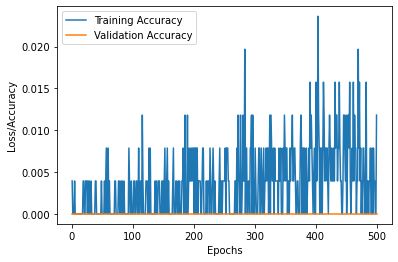

In [189]:
epochs = range(1, len(history10.epoch) + 1)
# plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history10.history['accuracy'], label='Training Accuracy')
# plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history10.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [190]:
x = [i for i in range(int(testing_features10[0,-1]+1), int(testing_features10[-1,-1]+2))]
y = testing_labels10
x_pred = testing_features10
y_pred = NN_model.predict(x_pred) 

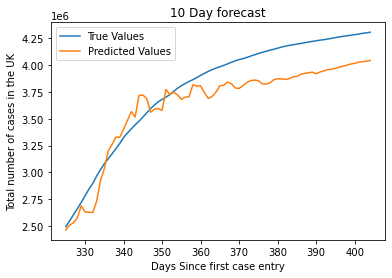

In [191]:
plt.plot(x, y, label="True Values")
plt.plot(x, y_pred, label="Predicted Values")
plt.xlabel("Days Since first case entry")
plt.ylabel("Total number of cases in the UK")
plt.title("10 Day forecast")
plt.legend()
plt.show()

In [192]:
window_size = 7
forecast = 50
features50, labels50 = create_features(pos_cases_df, window_size, forecast)

In [193]:
training_features50, testing_features50 = np.split(features50, [int(0.8*len(features50))])
training_labels50, testing_labels50 = np.split(labels50, [int(0.8*len(labels50))])

In [194]:
history50 = NN_model.fit(training_features50, training_labels50, epochs=500, validation_split=0.2)

Train on 228 samples, validate on 58 samples
Epoch 1/500
228/228 [==============================] - 0s 114us/step - loss: 128558.3350 - accuracy: 0.0000e+00 - val_loss: 493359.9310 - val_accuracy: 0.0000e+00
Epoch 2/500
228/228 [==============================] - 0s 105us/step - loss: 117890.1746 - accuracy: 0.0000e+00 - val_loss: 368195.1121 - val_accuracy: 0.0000e+00
Epoch 3/500
228/228 [==============================] - 0s 105us/step - loss: 109980.3288 - accuracy: 0.0000e+00 - val_loss: 610387.6659 - val_accuracy: 0.0000e+00
Epoch 4/500
228/228 [==============================] - 0s 101us/step - loss: 102583.5922 - accuracy: 0.0000e+00 - val_loss: 628671.2004 - val_accuracy: 0.0000e+00
Epoch 5/500
228/228 [==============================] - 0s 96us/step - loss: 102017.5657 - accuracy: 0.0000e+00 - val_loss: 693192.6444 - val_accuracy: 0.0000e+00
Epoch 6/500
228/228 [==============================] - 0s 110us/step - loss: 101527.5304 - accuracy: 0.0000e+00 - val_loss: 647988.4612 - val

228/228 [==============================] - 0s 105us/step - loss: 66671.7810 - accuracy: 0.0000e+00 - val_loss: 648516.8341 - val_accuracy: 0.0000e+00
Epoch 52/500
228/228 [==============================] - 0s 114us/step - loss: 63916.2042 - accuracy: 0.0000e+00 - val_loss: 660834.7543 - val_accuracy: 0.0000e+00
Epoch 53/500
228/228 [==============================] - 0s 105us/step - loss: 63442.1135 - accuracy: 0.0000e+00 - val_loss: 483693.5334 - val_accuracy: 0.0000e+00
Epoch 54/500
228/228 [==============================] - 0s 105us/step - loss: 66028.8262 - accuracy: 0.0000e+00 - val_loss: 617741.8858 - val_accuracy: 0.0000e+00
Epoch 55/500
228/228 [==============================] - 0s 105us/step - loss: 62724.6356 - accuracy: 0.0000e+00 - val_loss: 588295.0927 - val_accuracy: 0.0000e+00
Epoch 56/500
228/228 [==============================] - 0s 101us/step - loss: 58059.2987 - accuracy: 0.0000e+00 - val_loss: 561030.1487 - val_accuracy: 0.0000e+00
Epoch 57/500
228/228 [=============

228/228 [==============================] - 0s 105us/step - loss: 39761.9923 - accuracy: 0.0000e+00 - val_loss: 644392.1078 - val_accuracy: 0.0000e+00
Epoch 102/500
228/228 [==============================] - 0s 105us/step - loss: 33508.5892 - accuracy: 0.0000e+00 - val_loss: 768440.1078 - val_accuracy: 0.0000e+00
Epoch 103/500
228/228 [==============================] - 0s 96us/step - loss: 34776.5577 - accuracy: 0.0000e+00 - val_loss: 675052.4418 - val_accuracy: 0.0000e+00
Epoch 104/500
228/228 [==============================] - 0s 105us/step - loss: 33262.7731 - accuracy: 0.0000e+00 - val_loss: 721633.4461 - val_accuracy: 0.0000e+00
Epoch 105/500
228/228 [==============================] - 0s 101us/step - loss: 32571.7910 - accuracy: 0.0000e+00 - val_loss: 731595.9332 - val_accuracy: 0.0000e+00
Epoch 106/500
228/228 [==============================] - 0s 92us/step - loss: 51258.9375 - accuracy: 0.0000e+00 - val_loss: 532673.6595 - val_accuracy: 0.0000e+00
Epoch 107/500
228/228 [=========

228/228 [==============================] - 0s 105us/step - loss: 29283.0470 - accuracy: 0.0000e+00 - val_loss: 824539.2349 - val_accuracy: 0.0000e+00
Epoch 152/500
228/228 [==============================] - 0s 96us/step - loss: 41143.2268 - accuracy: 0.0000e+00 - val_loss: 664987.3405 - val_accuracy: 0.0000e+00
Epoch 153/500
228/228 [==============================] - 0s 96us/step - loss: 27493.9138 - accuracy: 0.0000e+00 - val_loss: 703016.4591 - val_accuracy: 0.0000e+00
Epoch 154/500
228/228 [==============================] - 0s 96us/step - loss: 26434.1272 - accuracy: 0.0000e+00 - val_loss: 756294.1659 - val_accuracy: 0.0000e+00
Epoch 155/500
228/228 [==============================] - 0s 110us/step - loss: 25043.5486 - accuracy: 0.0000e+00 - val_loss: 729876.4871 - val_accuracy: 0.0000e+00
Epoch 156/500
228/228 [==============================] - 0s 101us/step - loss: 23863.6466 - accuracy: 0.0000e+00 - val_loss: 797241.7522 - val_accuracy: 0.0000e+00
Epoch 157/500
228/228 [==========

228/228 [==============================] - 0s 101us/step - loss: 27925.3050 - accuracy: 0.0000e+00 - val_loss: 823665.6897 - val_accuracy: 0.0000e+00
Epoch 202/500
228/228 [==============================] - 0s 127us/step - loss: 22795.9259 - accuracy: 0.0000e+00 - val_loss: 718816.2328 - val_accuracy: 0.0000e+00
Epoch 203/500
228/228 [==============================] - 0s 118us/step - loss: 23417.7179 - accuracy: 0.0000e+00 - val_loss: 822723.4806 - val_accuracy: 0.0000e+00
Epoch 204/500
228/228 [==============================] - 0s 105us/step - loss: 25520.2636 - accuracy: 0.0000e+00 - val_loss: 807381.9957 - val_accuracy: 0.0000e+00
Epoch 205/500
228/228 [==============================] - 0s 101us/step - loss: 28421.6813 - accuracy: 0.0000e+00 - val_loss: 655955.2974 - val_accuracy: 0.0000e+00
Epoch 206/500
228/228 [==============================] - 0s 96us/step - loss: 29574.7667 - accuracy: 0.0000e+00 - val_loss: 794204.1638 - val_accuracy: 0.0000e+00
Epoch 207/500
228/228 [========

228/228 [==============================] - 0s 110us/step - loss: 28245.0580 - accuracy: 0.0000e+00 - val_loss: 769268.3470 - val_accuracy: 0.0000e+00
Epoch 252/500
228/228 [==============================] - 0s 110us/step - loss: 19020.3973 - accuracy: 0.0000e+00 - val_loss: 810567.3147 - val_accuracy: 0.0000e+00
Epoch 253/500
228/228 [==============================] - 0s 105us/step - loss: 20153.6227 - accuracy: 0.0000e+00 - val_loss: 773275.7823 - val_accuracy: 0.0000e+00
Epoch 254/500
228/228 [==============================] - 0s 101us/step - loss: 19814.3555 - accuracy: 0.0000e+00 - val_loss: 817874.1509 - val_accuracy: 0.0000e+00
Epoch 255/500
228/228 [==============================] - 0s 101us/step - loss: 24848.0268 - accuracy: 0.0000e+00 - val_loss: 859788.7802 - val_accuracy: 0.0000e+00
Epoch 256/500
228/228 [==============================] - 0s 101us/step - loss: 23237.8272 - accuracy: 0.0000e+00 - val_loss: 830463.6853 - val_accuracy: 0.0000e+00
Epoch 257/500
228/228 [=======

228/228 [==============================] - 0s 101us/step - loss: 24803.6471 - accuracy: 0.0000e+00 - val_loss: 750835.4784 - val_accuracy: 0.0000e+00
Epoch 302/500
228/228 [==============================] - 0s 101us/step - loss: 21856.4692 - accuracy: 0.0000e+00 - val_loss: 768664.4461 - val_accuracy: 0.0000e+00
Epoch 303/500
228/228 [==============================] - 0s 101us/step - loss: 17440.9485 - accuracy: 0.0000e+00 - val_loss: 794921.5797 - val_accuracy: 0.0000e+00
Epoch 304/500
228/228 [==============================] - 0s 101us/step - loss: 25218.6198 - accuracy: 0.0000e+00 - val_loss: 802106.2478 - val_accuracy: 0.0000e+00
Epoch 305/500
228/228 [==============================] - 0s 101us/step - loss: 20934.2907 - accuracy: 0.0000e+00 - val_loss: 852348.1983 - val_accuracy: 0.0000e+00
Epoch 306/500
228/228 [==============================] - 0s 101us/step - loss: 19872.2178 - accuracy: 0.0000e+00 - val_loss: 875837.5841 - val_accuracy: 0.0000e+00
Epoch 307/500
228/228 [=======

228/228 [==============================] - 0s 110us/step - loss: 16189.5506 - accuracy: 0.0000e+00 - val_loss: 831541.2996 - val_accuracy: 0.0000e+00
Epoch 352/500
228/228 [==============================] - 0s 101us/step - loss: 15595.7338 - accuracy: 0.0000e+00 - val_loss: 809319.2349 - val_accuracy: 0.0000e+00
Epoch 353/500
228/228 [==============================] - 0s 105us/step - loss: 16360.8197 - accuracy: 0.0000e+00 - val_loss: 845612.7953 - val_accuracy: 0.0000e+00
Epoch 354/500
228/228 [==============================] - 0s 101us/step - loss: 18317.6975 - accuracy: 0.0000e+00 - val_loss: 830620.6487 - val_accuracy: 0.0000e+00
Epoch 355/500
228/228 [==============================] - 0s 101us/step - loss: 12338.2635 - accuracy: 0.0000e+00 - val_loss: 807309.7026 - val_accuracy: 0.0000e+00
Epoch 356/500
228/228 [==============================] - 0s 105us/step - loss: 12938.6089 - accuracy: 0.0000e+00 - val_loss: 768810.3815 - val_accuracy: 0.0000e+00
Epoch 357/500
228/228 [=======

228/228 [==============================] - 0s 105us/step - loss: 12237.9739 - accuracy: 0.0000e+00 - val_loss: 819086.6832 - val_accuracy: 0.0000e+00
Epoch 402/500
228/228 [==============================] - 0s 101us/step - loss: 13905.9578 - accuracy: 0.0000e+00 - val_loss: 829246.8405 - val_accuracy: 0.0000e+00
Epoch 403/500
228/228 [==============================] - 0s 105us/step - loss: 12498.7699 - accuracy: 0.0000e+00 - val_loss: 767928.7802 - val_accuracy: 0.0000e+00
Epoch 404/500
228/228 [==============================] - 0s 105us/step - loss: 11673.7046 - accuracy: 0.0000e+00 - val_loss: 800882.4009 - val_accuracy: 0.0000e+00
Epoch 405/500
228/228 [==============================] - 0s 101us/step - loss: 11287.8713 - accuracy: 0.0000e+00 - val_loss: 806502.5194 - val_accuracy: 0.0000e+00
Epoch 406/500
228/228 [==============================] - 0s 101us/step - loss: 9723.1558 - accuracy: 0.0000e+00 - val_loss: 817161.7953 - val_accuracy: 0.0000e+00
Epoch 407/500
228/228 [========

228/228 [==============================] - 0s 105us/step - loss: 11391.1589 - accuracy: 0.0000e+00 - val_loss: 783019.1638 - val_accuracy: 0.0000e+00
Epoch 452/500
228/228 [==============================] - 0s 101us/step - loss: 11106.6811 - accuracy: 0.0000e+00 - val_loss: 799681.3017 - val_accuracy: 0.0000e+00
Epoch 453/500
228/228 [==============================] - 0s 96us/step - loss: 11881.6481 - accuracy: 0.0000e+00 - val_loss: 771649.5647 - val_accuracy: 0.0000e+00
Epoch 454/500
228/228 [==============================] - 0s 101us/step - loss: 13823.6246 - accuracy: 0.0000e+00 - val_loss: 794282.4116 - val_accuracy: 0.0000e+00
Epoch 455/500
228/228 [==============================] - 0s 101us/step - loss: 13359.4170 - accuracy: 0.0000e+00 - val_loss: 829862.7220 - val_accuracy: 0.0000e+00
Epoch 456/500
228/228 [==============================] - 0s 105us/step - loss: 15106.8318 - accuracy: 0.0000e+00 - val_loss: 820446.2996 - val_accuracy: 0.0000e+00
Epoch 457/500
228/228 [========

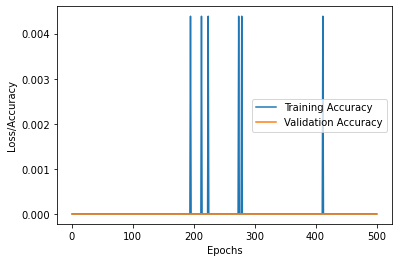

In [195]:
epochs = range(1, len(history50.epoch) + 1)
# plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history50.history['accuracy'], label='Training Accuracy')
# plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history50.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [196]:
x = [i for i in range(int(testing_features50[0,-1]+1), int(testing_features50[-1,-1]+2))]
y = testing_labels50
x_pred = testing_features50
y_pred = NN_model.predict(x_pred) 

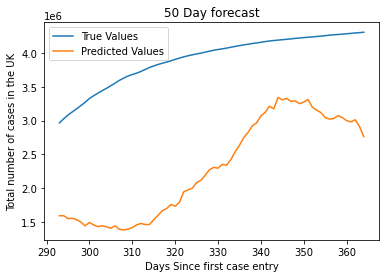

In [197]:
plt.plot(x, y, label="True Values")
plt.plot(x, y_pred, label="Predicted Values")
plt.xlabel("Days Since first case entry")
plt.ylabel("Total number of cases in the UK")
plt.title("50 Day forecast")
plt.legend()
plt.show()